# <h1><center>Ultimate Challenge</center></h1>

## <center>Hio Wa Mak</center>

## Import packages

In [1]:
#Import packages
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
#check current directory
#os.getcwd()

## Read in the data

In [3]:
# Read in logins data from a csv file
df_logins = pd.read_json('logins.json')
df_logins.head()
print(df_logins.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None


## Part 1: Exploratory Data Analysis

In [4]:
# Aggregate login counts based on 15-minute intervals
df_logins.index = df_logins['login_time']
df_logins_15m = df_logins.resample('15min').count().rename(columns={'login_time': 'login_counts'})
df_logins_15m

,login_counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


In [5]:
df_logins_15m = df_logins_15m.reset_index()
df_logins_15m.head()

,login_time,login_counts
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [6]:
df_logins_agg = df_logins_15m.copy()
df_logins_agg['year'] = df_logins_agg['login_time'].dt.year
df_logins_agg['month'] = df_logins_agg['login_time'].dt.month
df_logins_agg['day'] = df_logins_agg['login_time'].dt.day
df_logins_agg['hour'] = df_logins_agg['login_time'].dt.hour
df_logins_agg['day_of_week']=df_logins_agg['login_time'].dt.day_name()
# 0 = Monday, 1 = Tuesday, 2 = Wednesday, 3 = Thursday, 4 = Friday, 5 = Saturday, 6 = Sunday
df_logins_agg['day_of_week_num']=df_logins_agg['login_time'].dt.dayofweek
print(df_logins_agg.head())
print(df_logins_agg.tail())

           login_time  login_counts  year  month  day  hour day_of_week  \
0 1970-01-01 20:00:00             2  1970      1    1    20    Thursday   
1 1970-01-01 20:15:00             6  1970      1    1    20    Thursday   
2 1970-01-01 20:30:00             9  1970      1    1    20    Thursday   
3 1970-01-01 20:45:00             7  1970      1    1    20    Thursday   
4 1970-01-01 21:00:00             1  1970      1    1    21    Thursday   

   day_of_week_num  
0                3  
1                3  
2                3  
3                3  
4                3  
              login_time  login_counts  year  month  day  hour day_of_week  \
9783 1970-04-13 17:45:00             5  1970      4   13    17      Monday   
9784 1970-04-13 18:00:00             5  1970      4   13    18      Monday   
9785 1970-04-13 18:15:00             2  1970      4   13    18      Monday   
9786 1970-04-13 18:30:00             7  1970      4   13    18      Monday   
9787 1970-04-13 18:45:00         

### Plotting Time Series Data

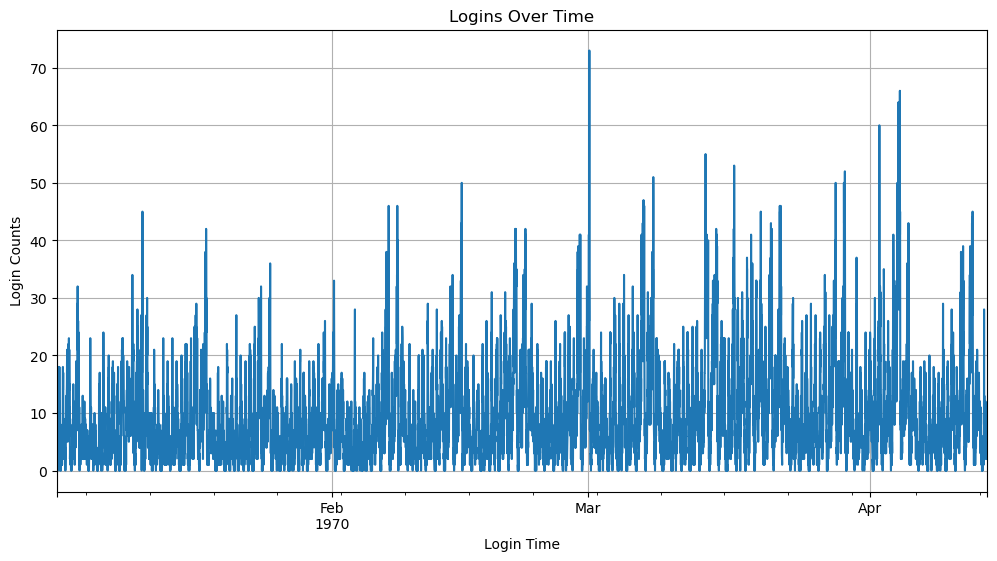

In [7]:
#Set login_time as index for plotting
df_logins_agg = df_logins_agg.set_index("login_time")

# Plot login counts over time
df_logins_agg['login_counts'].plot(figsize=(12, 6), linestyle='-')

# Formatting
plt.xlabel("Login Time")
plt.ylabel("Login Counts")
plt.title("Logins Over Time")
plt.grid(True)

# Show plot
plt.show()

In [8]:
df_logins_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   login_counts     9788 non-null   int64 
 1   year             9788 non-null   int32 
 2   month            9788 non-null   int32 
 3   day              9788 non-null   int32 
 4   hour             9788 non-null   int32 
 5   day_of_week      9788 non-null   object
 6   day_of_week_num  9788 non-null   int32 
dtypes: int32(5), int64(1), object(1)
memory usage: 420.6+ KB


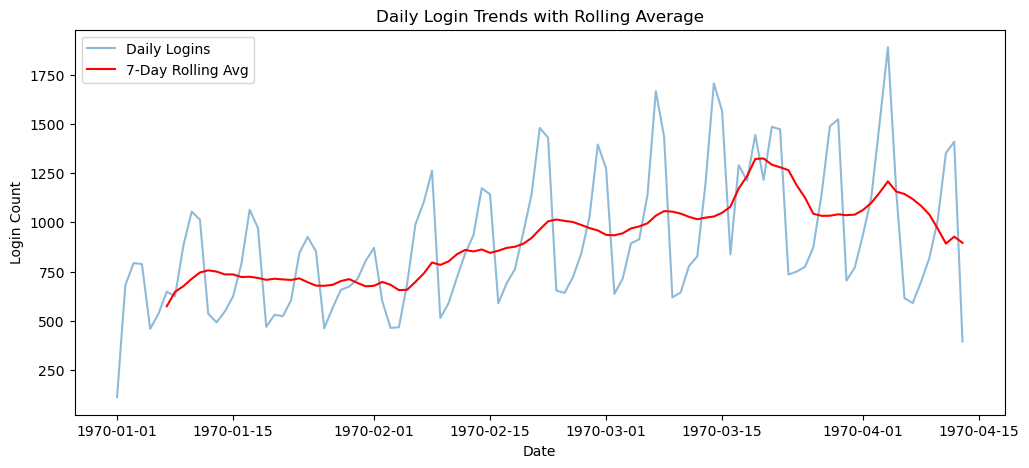

In [9]:
### Compress the data by adjusting time window
df_logins_daily = df_logins_agg[['login_counts']].resample('D').sum()
df_logins_daily['rolling_avg'] = df_logins_daily['login_counts'].rolling(window=7).mean()  # 7-day moving average

# Plot daily trend
plt.figure(figsize=(12, 5))
plt.plot(df_logins_daily.index, df_logins_daily['login_counts'], label="Daily Logins", alpha=0.5)
plt.plot(df_logins_daily.index, df_logins_daily['rolling_avg'], label="7-Day Rolling Avg", color='red')
plt.xlabel("Date")
plt.ylabel("Login Count")
plt.title("Daily Login Trends with Rolling Average")
plt.legend()
plt.show()


There is an overall increasing trend from January to April. Furthermore, it is apparent that there is cyclical weekly pattern in the data.

In [10]:
df_logins_daily.head()

,login_counts,rolling_avg
login_time,,
1970-01-01,112,NaN
1970-01-02,681,NaN
1970-01-03,793,NaN
1970-01-04,788,NaN
1970-01-05,459,NaN


In [11]:
df_logins_agg.head()

,login_counts,year,month,day,hour,day_of_week,day_of_week_num
login_time,,,,,,,
1970-01-01 20:00:00,2,1970,1,1,20,Thursday,3
1970-01-01 20:15:00,6,1970,1,1,20,Thursday,3
1970-01-01 20:30:00,9,1970,1,1,20,Thursday,3
1970-01-01 20:45:00,7,1970,1,1,20,Thursday,3
1970-01-01 21:00:00,1,1970,1,1,21,Thursday,3


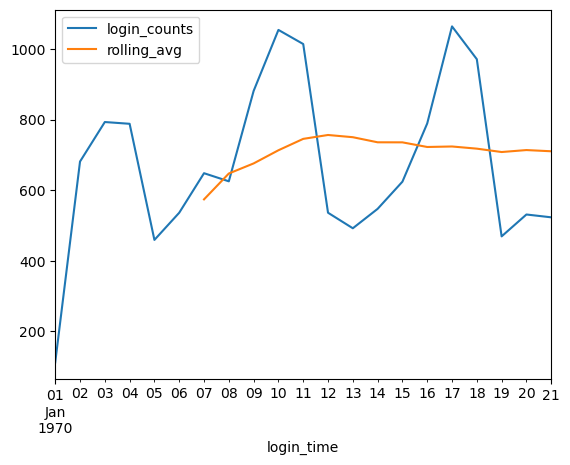

In [12]:
### Zoom in to a three week period
df_logins_daily.loc['1970-01-01':'1970-01-21'].plot()
plt.show()

January 01, 1970 is a Thursday. It is apparent that login_counts are higher during the weekend days (i.e., Friday, Saturday, and Sunday).

### Let's look at hourly

In [13]:
### Compress the data by adjusting time window
df_logins_hourly = df_logins_agg[['login_counts']].resample('h').sum()
df_logins_hourly.head()

,login_counts
login_time,
1970-01-01 20:00:00,24
1970-01-01 21:00:00,9
1970-01-01 22:00:00,21
1970-01-01 23:00:00,58
1970-01-02 00:00:00,53


### Weekend data

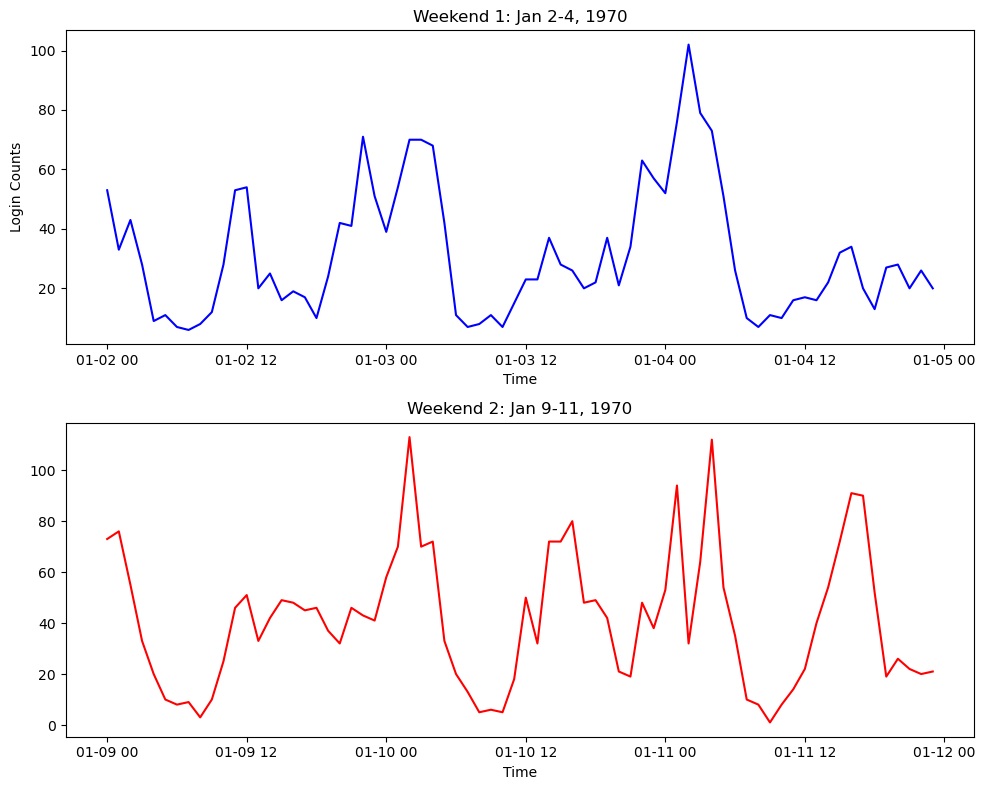

In [14]:
### Zoom into two three-day weekends (Friday - Sunday)
# Extract first weekend
weekend1 = df_logins_hourly.loc['1970-01-02':'1970-01-04']

# Extract second weekend
weekend2 = df_logins_hourly.loc['1970-01-09':'1970-01-11']

# Create subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot first weekend
axes[0].plot(weekend1.index, weekend1['login_counts'], color='blue')
axes[0].set_title("Weekend 1: Jan 2-4, 1970")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Login Counts")

# Plot second weekend
axes[1].plot(weekend2.index, weekend2['login_counts'], color='red')
axes[1].set_title("Weekend 2: Jan 9-11, 1970")
axes[1].set_xlabel("Time")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Weekday Data

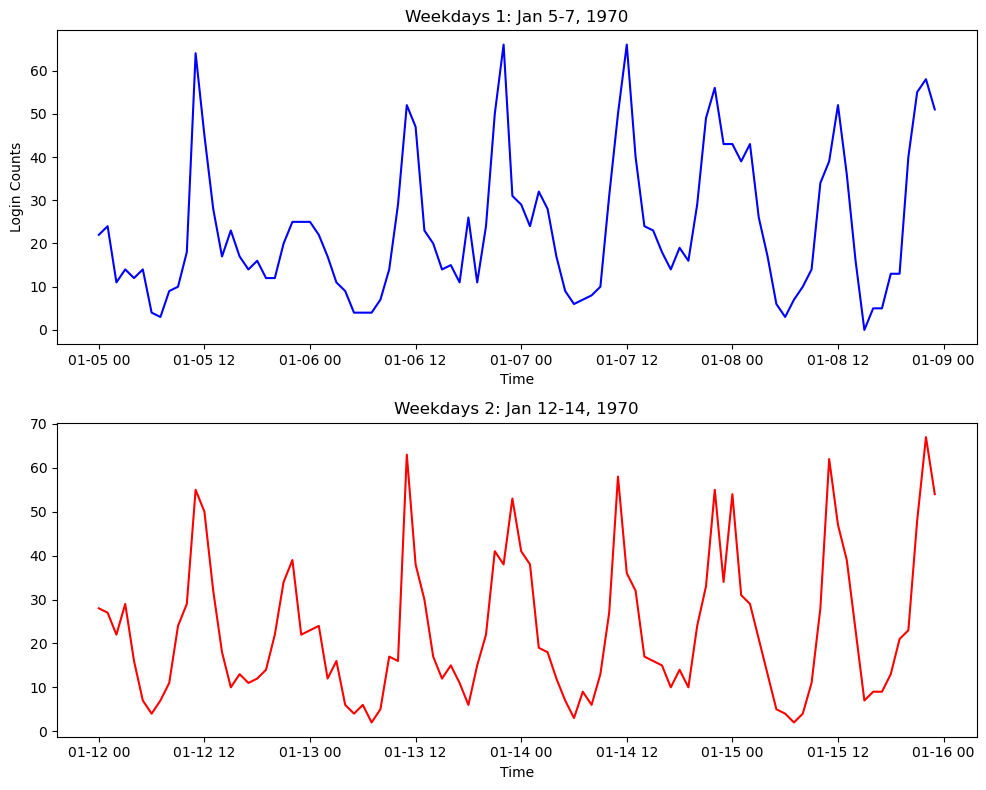

In [15]:
### Zoom into two four-day weekdays (Monday - Thursday)
# Extract first weekdays
weekdays1 = df_logins_hourly.loc['1970-01-05':'1970-01-08']

# Extract second weekdays
weekdays2 = df_logins_hourly.loc['1970-01-12':'1970-01-15']

# Create subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot first week
axes[0].plot(weekdays1.index, weekdays1['login_counts'], color='blue')
axes[0].set_title("Weekdays 1: Jan 5-7, 1970")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Login Counts")

# Plot second week
axes[1].plot(weekdays2.index, weekdays2['login_counts'], color='red')
axes[1].set_title("Weekdays 2: Jan 12-14, 1970")
axes[1].set_xlabel("Time")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

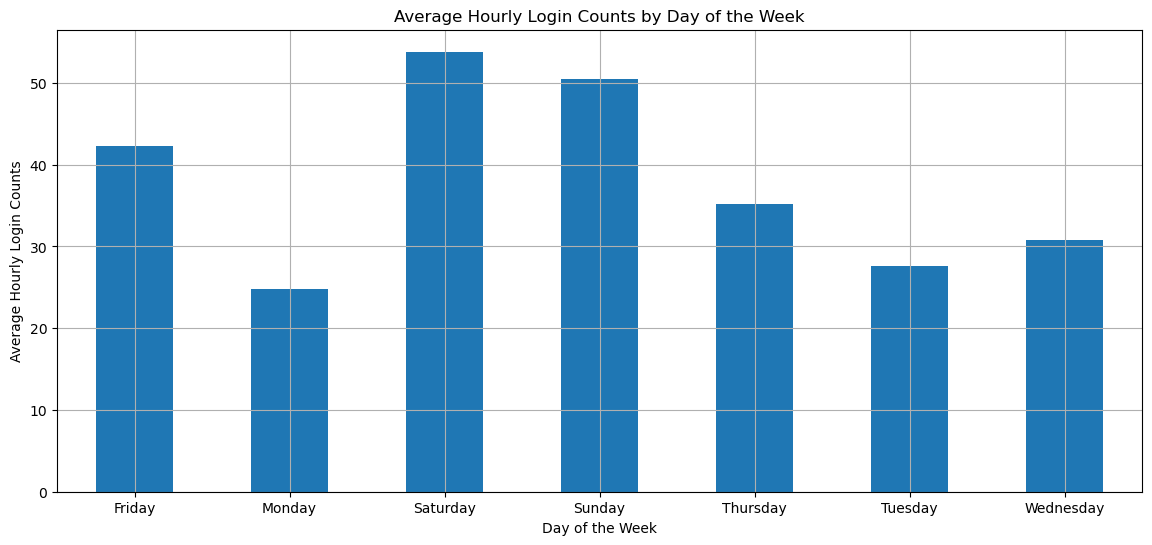

In [16]:
# Across all data
day_of_week_hourly_avg = df_logins_hourly.groupby(df_logins_hourly.index.day_name())['login_counts'].mean()

# Plot the average login counts by hour
plt.figure(figsize=(14, 6))
day_of_week_hourly_avg.plot(kind='bar', title='Average Hourly Login Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Hourly Login Counts')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

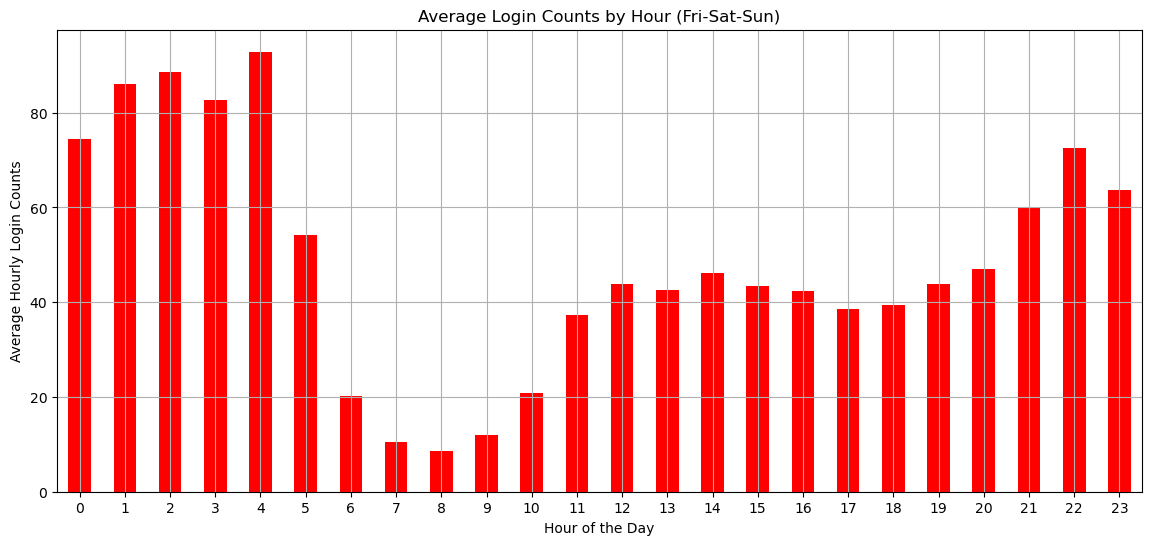

In [17]:
# Across all weekends
# Weekend Average Hourly Login Counts
# Extract day of the week (0=Monday, 6=Sunday)
df_logins_hourly['day_of_week'] = df_logins_hourly.index.dayofweek

# Filter for Friday (4), Saturday (5), and Sunday (6)
weekend_logins = df_logins_hourly[df_logins_hourly['day_of_week'].isin([4, 5, 6])]

# Compute average logins per hour for Fri-Sat-Sun
hourly_avg_weekend = weekend_logins.groupby(weekend_logins.index.hour)['login_counts'].mean()

# Plot the data
plt.figure(figsize=(14, 6))
hourly_avg_weekend.plot(kind='bar', title='Average Login Counts by Hour (Fri-Sat-Sun)', color='red')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Hourly Login Counts')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

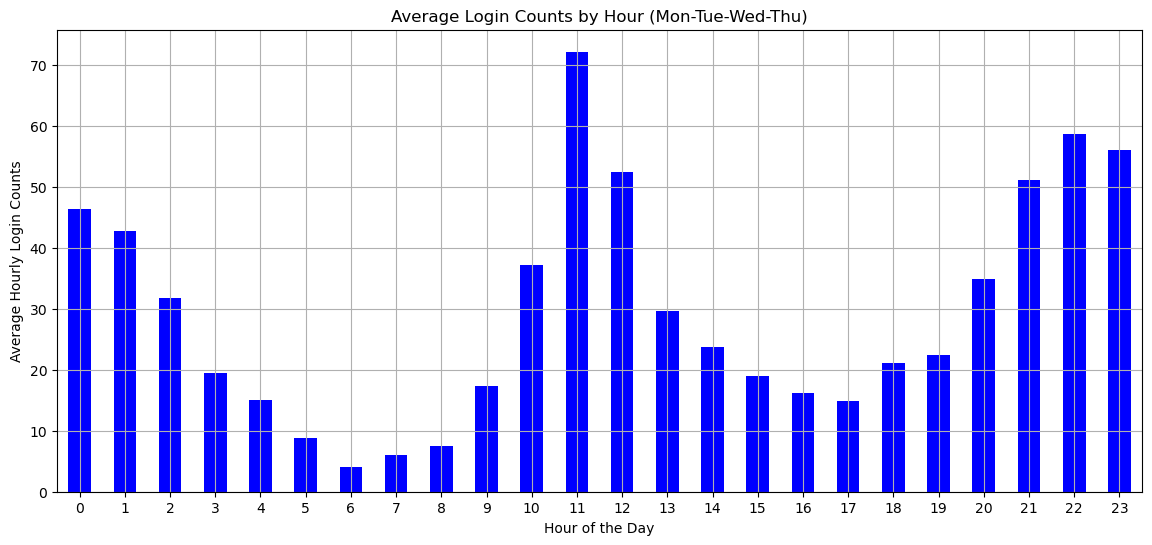

In [18]:
# Across all weekdays
# Weekday Average Hourly Login Counts

# Filter for Monday (0), Tuesday (1), Wednesday (2), and Thursday (3)
weekday_logins = df_logins_hourly[df_logins_hourly['day_of_week'].isin([0, 1, 2, 3])]

# Compute average logins per hour for Fri-Sat-Sun
hourly_avg_weekday = weekday_logins.groupby(weekday_logins.index.hour)['login_counts'].mean()

# Plot the data
plt.figure(figsize=(14, 6))
hourly_avg_weekday.plot(kind='bar', title='Average Login Counts by Hour (Mon-Tue-Wed-Thu)', color='blue')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Hourly Login Counts')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

## Findings

During weekends (Friday to Sunday), peak hours are between 9PM to 4AM and the down hours are between 6AM to 10AM. During weekdays (Monday to Thursday), peak hours are between 10AM to 12PM and 8PM to 2AM. Overall, weekends have more logins than weekdays.

## Part 2: Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs. <br>
1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric? <br>

**ANS:** On weekdays, Ultimate Gotham is most active at night and Ultimate Metropolis is most active during the day. By reimbursing toll costs, hopefully the Metropolis drivers can share the traffic burden in Gotham at night (peak hours) and the Gotham drivers can lower the traffic burden in Metropolis during the day (peak hours). The experiment would be to reimburse Ultimate drivers in the two cities for all toll costs during weekdays. The Key measure of success of this experiment is to measure the total amount of toll costs reimbursed for the Ultimate Gotham and Metropolis drivers before and after the reimbursement program.<br>

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: <br>
a) how you will implement the experiment <br>
b) what statistical test(s) you will conduct to verify the significance of the observation <br>
c) how you would interpret the results and provide recommendations to the cityoperations team along with any caveats. <br>

**ANS:**  <br>
a) Measure the total number of toll use by the Ultimate drivers of the two cities during the weekdays for two weeks before the toll costs reimbursement program starts. Advertise and carry out the toll costs reimbursement for a month so that most drivers are now aware of the program. Then measure the total number of toll use by the Ultimate drivers of the two cities during the weekdays for two weeks. <br>

b) I will use t-test to compare the total number of toll use by Ultimate drivers in the two cities in the two weeks preceding the reimbursement program and the total number of toll use by Ultimate drivers in the two citites in the two weeks after the reimbursement program is put in place for two months. <br>

c) If the toll use after the reimbursement program is introduced is significantly higher than that before the reimbursement program (p < .05), then, the program is a success regarding encouraging drivers to be available in both cities during weekdays. However, one caveat is to make sure that the additional revenue gain after the program is introduced can cover the toll costs reimbursed to drivers. <br>

## Part 3: Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

Data description <br>
**● city:** city this user signed up in <br>
**● phone:** primary device for this user <br>
**● signup_date:** date of account registration; in the form ‘YYYYMMDD’ <br>
**● last_trip_date:** the last time this user completed a trip; in the form ‘YYYYMMDD’ <br>
**● avg_dist:** the average distance in miles per trip taken in the first 30 days after signup <br>
**● avg_rating_by_driver:** the rider’s average rating over all of their trips <br>
**● avg_rating_of_driver:** the rider’s average rating of their drivers over all of their trips  <br>
**● surge_pct:** the percent of trips taken with surge multiplier > 1 <br>
**● avg_surge:** The average surge multiplier over all of this user’s trips <br>
**● trips_in_first_30_days:** the number of trips this user took in the first 30 days after signing up <br>
**● ultimate_black_user:** TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise <br>
**● weekday_pct:** the percent of the user’s trips occurring during a weekday <br>

### Read in Data

In [19]:
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Note that `avg_rating_of_driver`, `phone`, and `avg_rating_by_driver` contains missing data.

In [21]:
# Impute missing data
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())
df = df.dropna(subset=['phone'])

In [22]:
# Convert date variables to datetime object
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  int32         
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int32(1), int64(1

### Compute Target Variable

A user is considered retained if they were “active” (i.e. took a trip) in the preceding 30 days.

In [23]:
# Get the most recent trip date in the dataset
latest_date = df['last_trip_date'].max()

# Define the cutoff date for retention (30 days before latest trip date)
cutoff_date = latest_date - pd.Timedelta(days=30)

# Create the retained column: 1 if last_trip_date is within the last 30 days, else 0
df['retained'] = (df['last_trip_date'] >= cutoff_date).astype(int)

# Create a recency column: days since last trip date
df['recency'] = (latest_date - df['last_trip_date']).dt.days

df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,recency
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1,14
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0,57
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0,175
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1,2
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0,108


### Retention Rate

In [24]:
# Retention rate
retention_rate = df['retained'].mean() * 100
print(f"{retention_rate:.2f}% of the users were retained")

37.64% of the users were retained


### EDA

In [25]:
#Write a function to plot through freqeuncy across all categorical variables
def plot_categorical_variables(df):
    '''A function that calculate the frequency and percentage of each category across all categorical variables'''
    # Get the list of categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    # Loop through each categorical column
    for column in categorical_columns:
        counts = df[column].value_counts()
        percs = df[column].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
        # Print column name as title
        print(f"\033[1m{column.center(50)}\033[0m")
        # Print an empty line
        print()
        # Print the statistics
        print(pd.concat([counts,percs], axis=1, keys=['count', 'percentage']))
        
    # Add a separator
        print("\n" + "="*50 + "\n")

plot_categorical_variables(df)  

                       city                       

                count percentage
city                            
Winterfell      23125      46.6%
Astapor         16413      33.1%
King's Landing  10066      20.3%


                      phone                       

         count percentage
phone                    
iPhone   34582      69.7%
Android  15022      30.3%




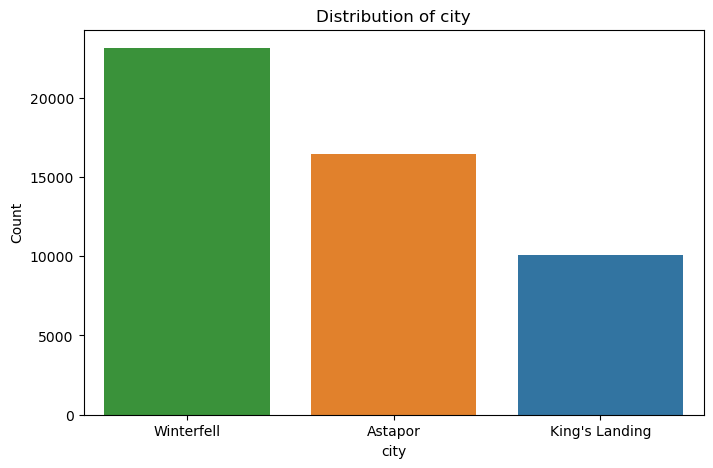

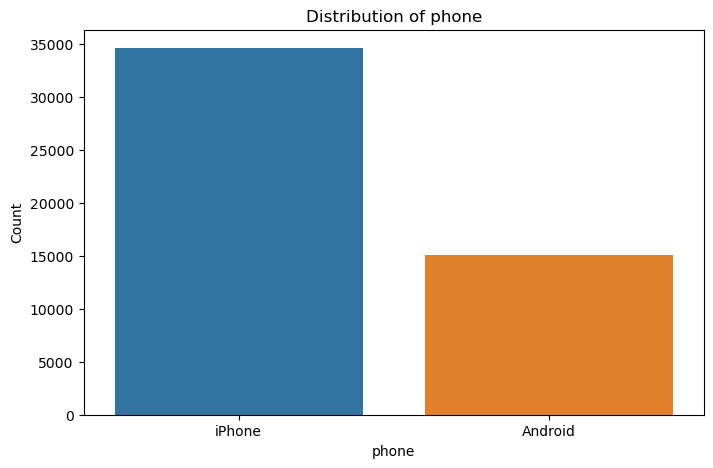

In [26]:
#Write a function to plot through freqeuncy across all categorical variables
def plot_categorical_variables(df):
    '''A function that calculate the frequency and percentage of each category across all categorical variables'''
    # Get the list of categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    # Loop through each categorical column
    for column in categorical_columns:
       
    # Plot frequency distribution
        plt.figure(figsize=(8, 5))
        sns.countplot(x=column, data=df, order=df[column].value_counts().index, hue=column, legend=False)
        plt.xlabel(column)
        plt.ylabel("Count")
        plt.title(f"Distribution of {column}")
        plt.show()
              
plot_categorical_variables(df)  

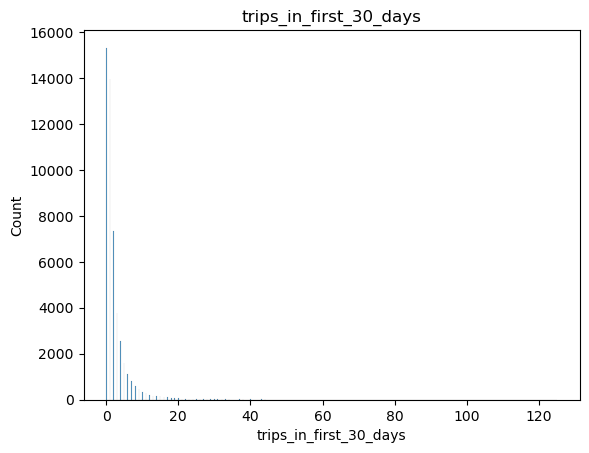

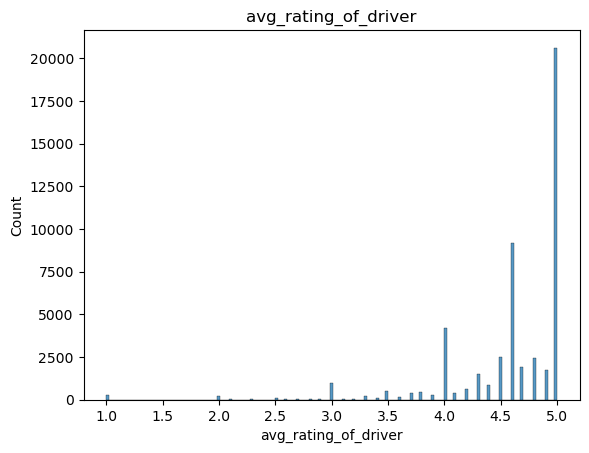

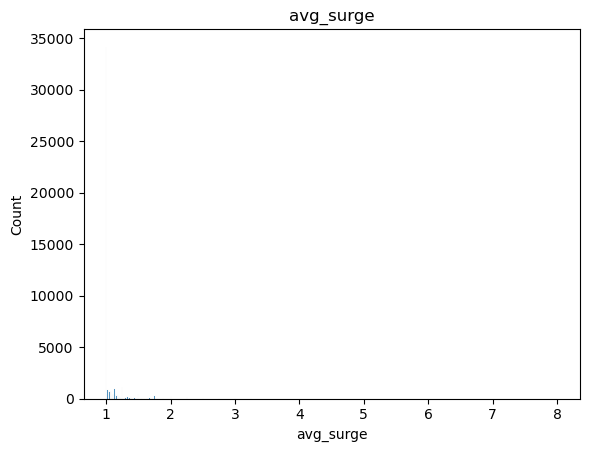

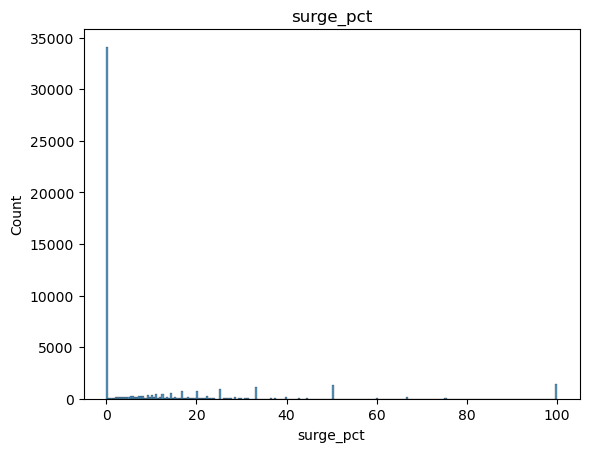

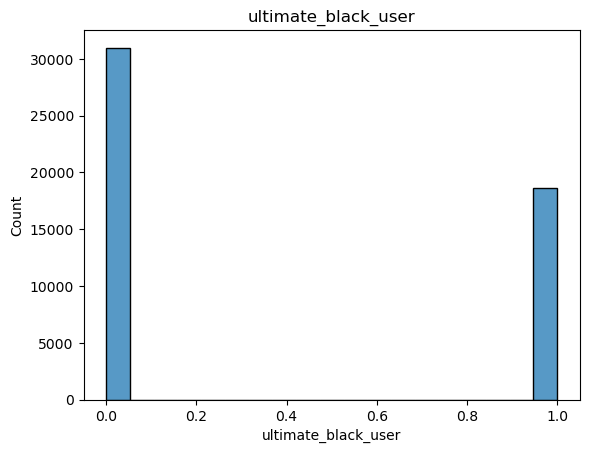

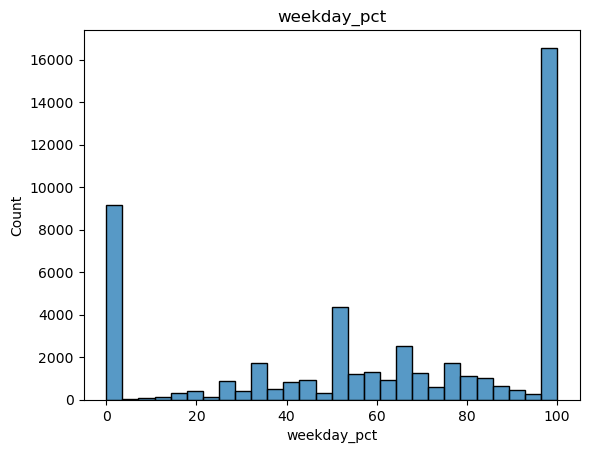

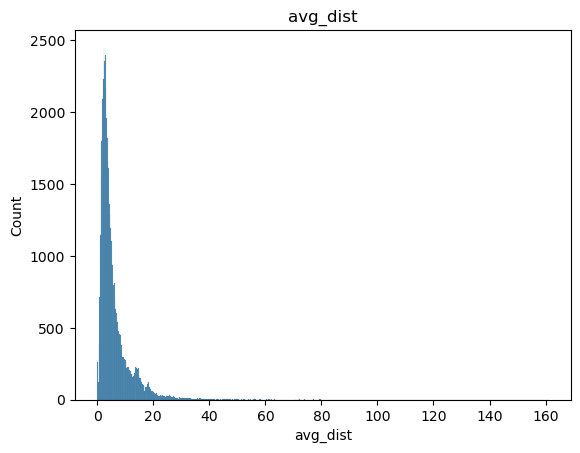

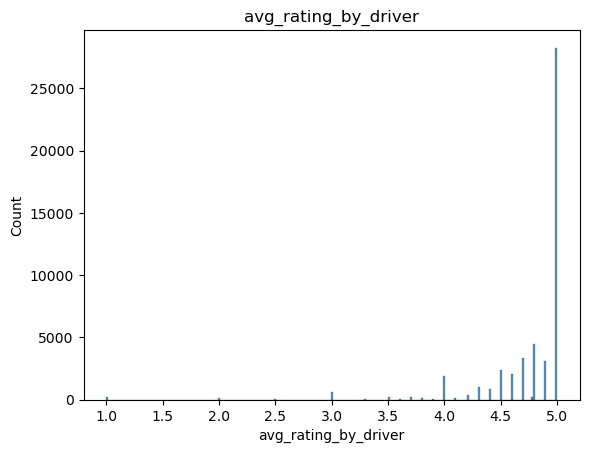

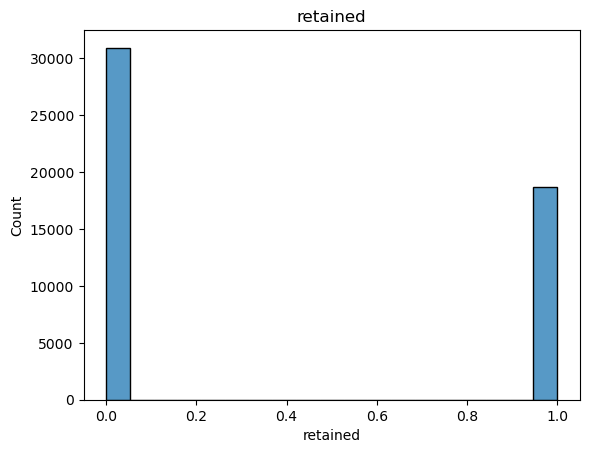

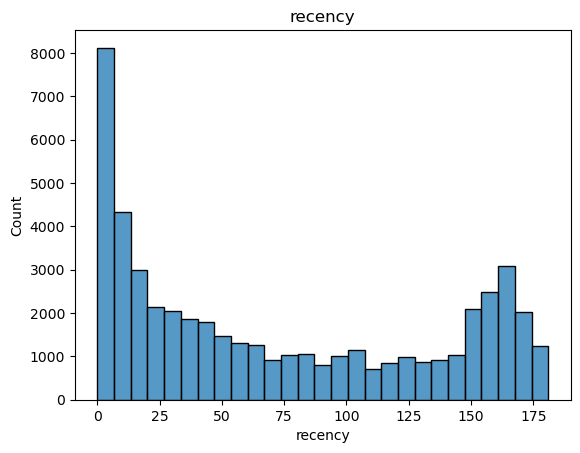

In [27]:
### Explore continuous variables
cont_columns = df.select_dtypes(include=['float64', 'int']).columns

# Loop through each continuous variables
for column in cont_columns:
    sns.histplot(df[column])
    plt.title(column)
    plt.show()

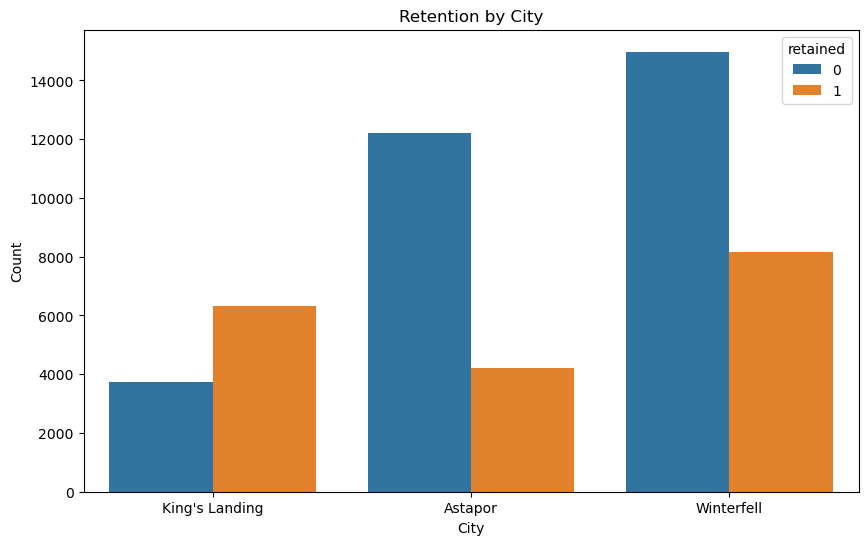

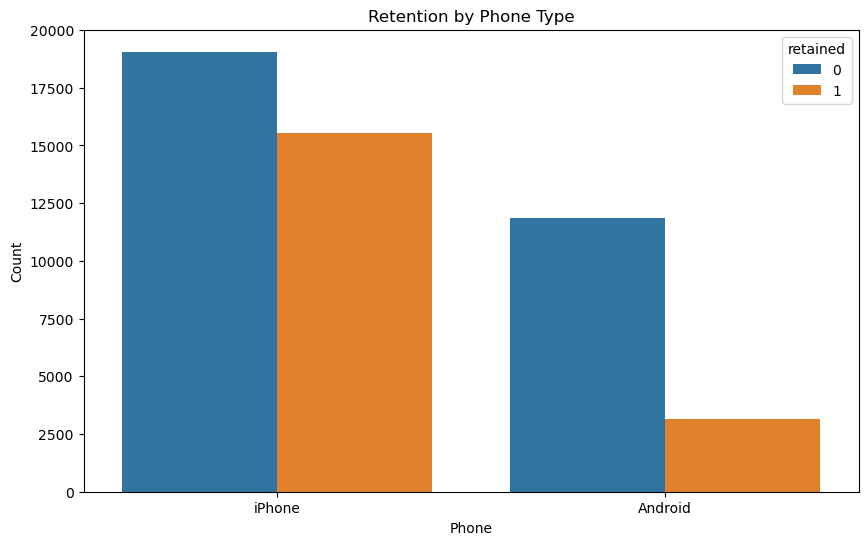

In [28]:
# Retention by City
plt.figure(figsize=(10, 6))
sns.countplot(x='city', hue='retained', data=df)
plt.title('Retention by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.show()

# Retention by Phone Type
plt.figure(figsize=(10, 6))
sns.countplot(x='phone', hue='retained', data=df)
plt.title('Retention by Phone Type')
plt.xlabel('Phone')
plt.ylabel('Count')
plt.show()

In [29]:
#Recode categorical variables using one-hot encoding (for machine learning models)
df_one_hot = pd.get_dummies(df, columns=['city', 'phone'])
 # Drop the reference category of one-hot coded variables (i.e., dummy coding)
df_dummy = df_one_hot.drop(columns=['city_Astapor', 'phone_Android'])
df_dummy.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,recency,city_King's Landing,city_Winterfell,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,1,14,True,False,True
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,0,57,False,False,False
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,0,175,False,False,True
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,1,2,True,False,True
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,108,False,True,False


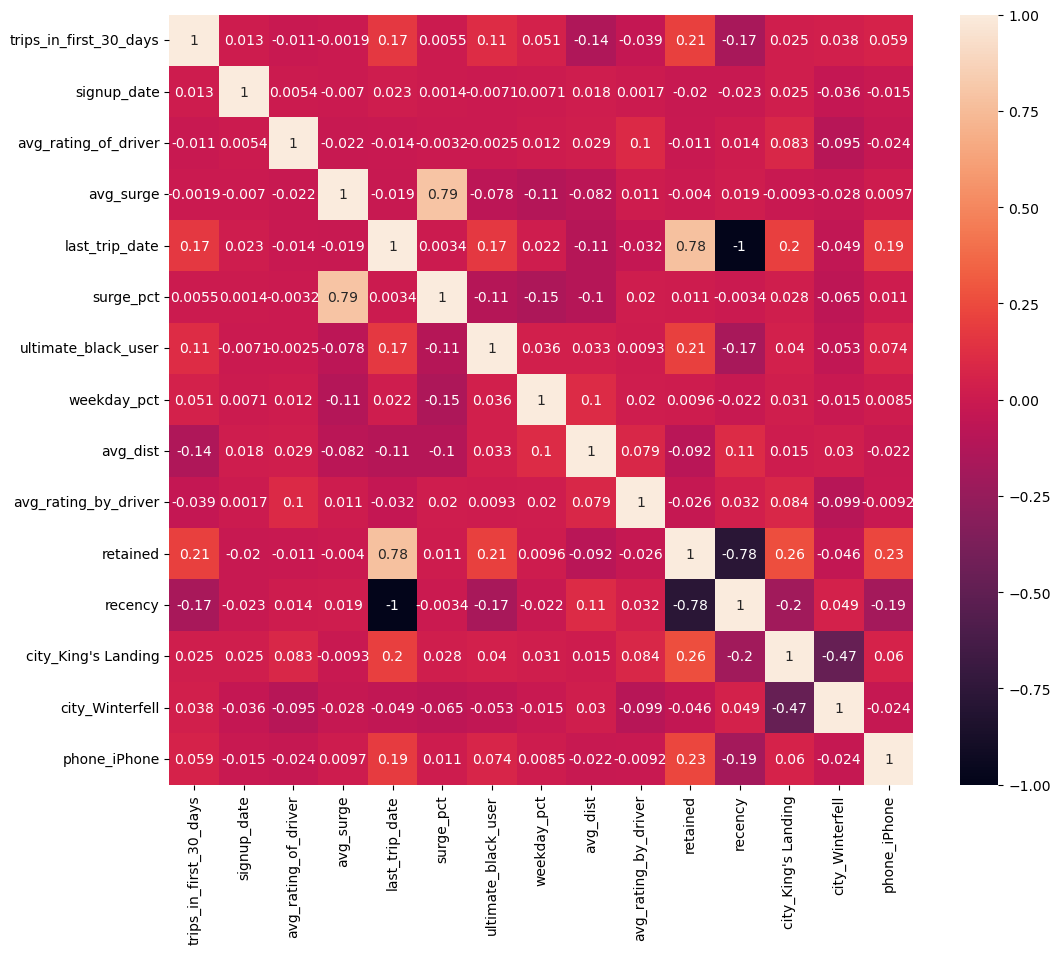

In [30]:
# Make a heatmap of the data
plt.figure(figsize=(12, 10))
sns.heatmap(df_dummy.corr(), annot=True)
plt.show()

`trips_in_first_30_days`, `last_trip_date`, `ultimate_black_user`, `city_King's Landing`, and `phone_iphone` are all positively associated with higher retention rate.

### Feature Engineering

In [31]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49604 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  49604 non-null  int64         
 1   signup_date             49604 non-null  datetime64[ns]
 2   avg_rating_of_driver    49604 non-null  float64       
 3   avg_surge               49604 non-null  float64       
 4   last_trip_date          49604 non-null  datetime64[ns]
 5   surge_pct               49604 non-null  float64       
 6   ultimate_black_user     49604 non-null  int32         
 7   weekday_pct             49604 non-null  float64       
 8   avg_dist                49604 non-null  float64       
 9   avg_rating_by_driver    49604 non-null  float64       
 10  retained                49604 non-null  int32         
 11  recency                 49604 non-null  int64         
 12  city_King's Landing     49604 non-null  bool       

In [32]:
df2 = df_dummy.copy()

#Drop date columns
df2 = df2.drop(columns=['signup_date', 'last_trip_date'])

### Training and Testing Data Split

In [33]:
# Select features (X) and target variable (y)
X = df2.drop(columns=['retained', 'recency']) # Drop recency because it is directly related to outcome
y = df2["retained"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30, stratify=y)

### Standardize Features

In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#check after standardization
print(np.mean(X, axis=0), np.std(X, axis=0))
print(np.mean(X_train, axis=0), np.std(X_train, axis=0))

trips_in_first_30_days     2.277256
avg_rating_of_driver       4.601482
avg_surge                  1.074991
surge_pct                  8.875314
ultimate_black_user        0.375212
weekday_pct               60.883832
avg_dist                   5.785418
avg_rating_by_driver       4.777862
city_King's Landing        0.202927
city_Winterfell            0.466192
phone_iPhone               0.697162
dtype: float64 trips_in_first_30_days     3.793262
avg_rating_of_driver       0.565222
avg_surge                  0.222664
surge_pct                 19.988816
ultimate_black_user        0.484178
weekday_pct               37.085865
avg_dist                   5.669652
avg_rating_by_driver       0.446216
city_King's Landing        0.402179
city_Winterfell            0.498856
phone_iPhone               0.459486
dtype: float64
[ 1.89080802e-17 -1.01559310e-15  2.87250027e-16  4.54557888e-17
  1.32738543e-17  2.23077148e-16 -2.78846436e-17 -3.74437286e-16
  1.06954797e-17 -9.49223825e-17 -6.57008040e-17

### Random Forest

In [35]:
# Fit a random forest model

# Define parameters for randomized search

param_dist = {
    'n_estimators': [50, 100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'class_weight': [None, 'balanced']
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4],
}

# Set up the random forest model
rf = RandomForestClassifier(random_state=42)

# Setup the RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=param_dist,
                               n_iter=20,  
                               cv=5, 
                               scoring="accuracy",
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)  

# Time the fitting process
start_time = time.time()
rf_random.fit(X_train, y_train)
end_time = time.time()
est_time = (end_time - start_time)

# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

# Print the best parameters
print("Best hyperparameters found:", rf_random.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Estimation time: 3.03 minutes
Best hyperparameters found: {'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': None}


In [36]:
# Obtain evaluation metrics for training data:
# Step 1: Use cross_val_predict to get cross-validated predictions for training data
y_train_pred = cross_val_predict(rf_random.best_estimator_, X_train, y_train, cv=5)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Step 3: Generate the classification report
rf_class_report = classification_report(y_train, y_train_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nRandom Forest Classification Report:")
print(rf_class_report)

Confusion Matrix:
[[20077  3123]
 [ 4900  9103]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83     23200
           1       0.74      0.65      0.69     14003

    accuracy                           0.78     37203
   macro avg       0.77      0.76      0.76     37203
weighted avg       0.78      0.78      0.78     37203



### Logistic Regression

In [37]:
# Fit a logistic regression model
# Define parameters for randomized search
param_distributions = {
    'C': uniform(0.001, 100),  # Uniform distribution for C, ranges from 0.001 to 100
    'penalty': ['l1', 'l2'],   # Regularization type (L1 = Lasso, L2 = Ridge)
    'solver': ['liblinear', 'saga'],  # Solvers that support L1 and L2
    'class_weight': [None, 'balanced']
}

# Set up the logistic regression model
logreg = LogisticRegression()

# Perform randomized search with 10 iterations and 5-fold cross-validation
logreg_random = RandomizedSearchCV(estimator = logreg, 
                                   param_distributions = param_distributions, 
                                   n_iter=20, # Number of different combinations to try
                                   cv=5, 
                                   scoring='recall', 
                                   random_state=42, 
                                   verbose=1,
                                   n_jobs=-1) # Use all available cores (8)

# Time the fitting process
start_time = time.time()
logreg_random.fit(X_train, y_train)
end_time = time.time()
est_time = (end_time - start_time)

# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

# Print the best parameters
print("Best hyperparameters found:", logreg_random.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Estimation time: 0.05 minutes
Best hyperparameters found: {'C': 33.371861113902185, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


In [38]:
# Obtain evaluation metrics for training data:
# Step 1: Use cross_val_predict to get cross-validated predictions for training data
y_train_pred = cross_val_predict(logreg_random.best_estimator_, X_train, y_train, cv=5)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Step 3: Generate the classification report
logreg_class_report = classification_report(y_train, y_train_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nLogistic Regression Classification Report:")
print(logreg_class_report)

Confusion Matrix:
[[16854  6346]
 [ 4753  9250]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75     23200
           1       0.59      0.66      0.63     14003

    accuracy                           0.70     37203
   macro avg       0.69      0.69      0.69     37203
weighted avg       0.71      0.70      0.70     37203



The accuracy score of the random forest model is 0.78, which is higher than the logistic regression model (0.70). Therefore, the random forest model is selected as the best model here. The random forest model has a precision of 0.77, a recall of 0.76, and a f-1 score of 0.76.  

## Best Model: Random Forest Model

### AUC

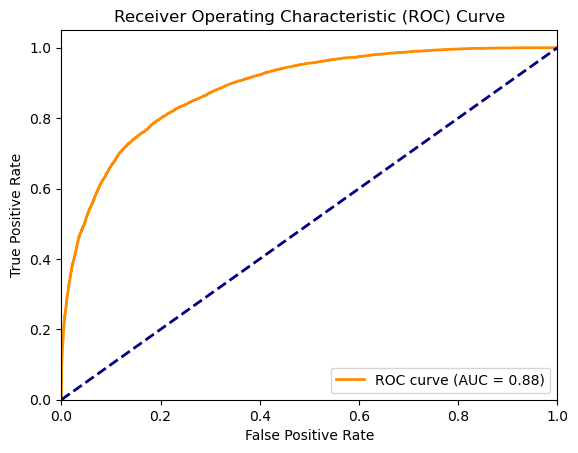

In [39]:
# Add ROC curve
# Step 1: Predict probabilities for the training set
y_train_proba = rf_random.best_estimator_.predict_proba(X_train)[:, 1] #for the positive class (1)

# Step 2: Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)

# Step 3: Calculate the Area Under the Curve (AUC) score
roc_auc = auc(fpr, tpr)

# Step 4: Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

AUC score = 0.88

### Feature Importance

In [40]:
# Examine feature coefficient from the best model
importances = rf_random.best_estimator_.feature_importances_  # Get feature importances

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 10 most important features
print(feature_importance_df.head(10))

                   Feature  Importance
7     avg_rating_by_driver    0.196297
3                surge_pct    0.143745
8      city_King's Landing    0.140825
5              weekday_pct    0.115651
2                avg_surge    0.091598
10            phone_iPhone    0.076511
0   trips_in_first_30_days    0.067046
6                 avg_dist    0.064669
4      ultimate_black_user    0.056396
1     avg_rating_of_driver    0.032445


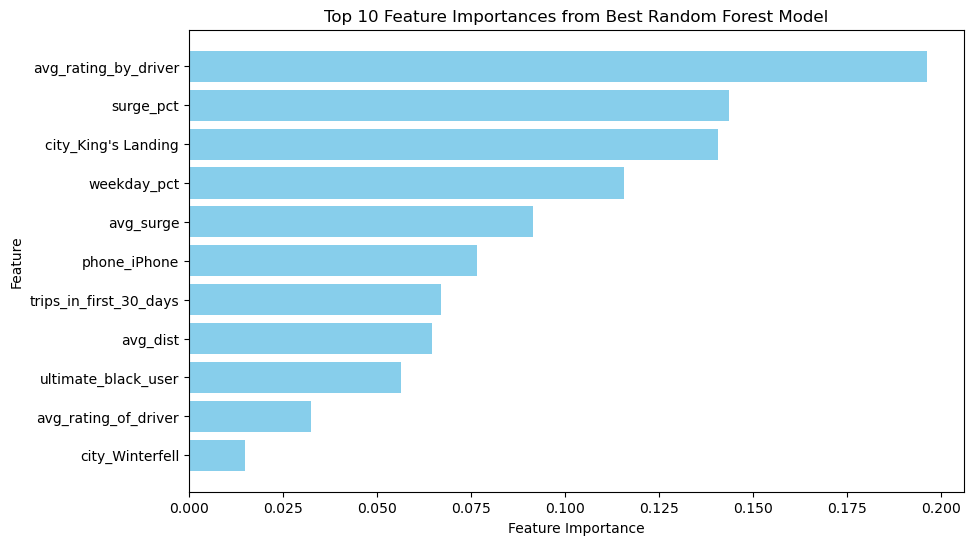

In [41]:
# Select the top 10 most important features
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances from Best Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.show()

Based on the random forest model, the top five features predicting retention are: 
1) `avg_rating_by_driver`: the rider’s average rating over all of their trips, <br>
2) `surge_pct`: the percent of trips taken with surge multiplier > 1,  <br>
3) `city_King's Landing`: city this user signed up in,  <br>
4) `weekday_pct`: the percent of the user’s trips occurring during a weekday, and  <br>
5) `avg_surge`: the average surge multiplier over all of this user’s trips.  <br>

### Model Evaluation Using Testing Data

In [42]:
# Evaluate on the test set
y_pred = rf_random.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate the classification report
class_report = classification_report(y_test, y_pred)

print("\nRandom Forest Classification Report on Testing Data:")
print(class_report)


Random Forest Classification Report on Testing Data:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      7733
           1       0.74      0.65      0.70      4668

    accuracy                           0.78     12401
   macro avg       0.77      0.76      0.76     12401
weighted avg       0.78      0.78      0.78     12401



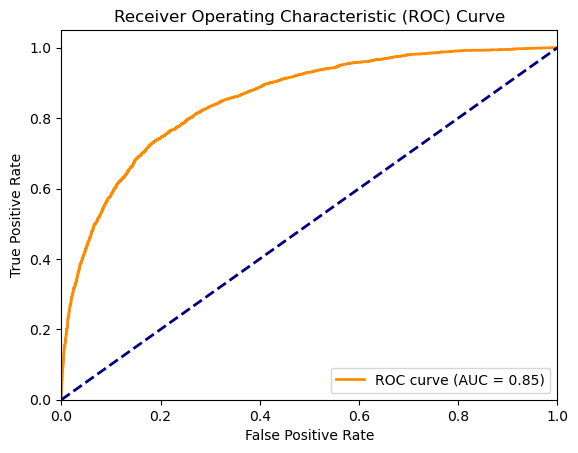

In [43]:
# Add ROC curve
# Step 1: Predict probabilities for the testing set
y_test_proba = rf_random.best_estimator_.predict_proba(X_test)[:, 1] #for the positive class (1)

# Step 2: Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Step 3: Calculate the Area Under the Curve (AUC) score
roc_auc = auc(fpr, tpr)

# Step 4: Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

When evaluated on testing data, similar accuracy (0.78), precision (0.77), recall (0.76), f1-score (0.76), and AUC (0.85) scores were obtained, indicating that the model generalizes well to unseen data.

### Suggestions

To enhance rider retention, Ultimate could focus on improving the rider experience, as reflected in trip ratings. Gathering feedback from riders who provide low ratings could help identify key areas for improvement. Additionally, they should examine the impact of surge pricing on retention. Expanding rider sign-ups in King's Landing, which shows a higher retention rate, could be beneficial, while investigating the factors behind lower retention rates in Astapor and Winterfell may reveal areas for targeted interventions. Lastly, analyzing whether weekday or weekend riders are more likely to be retained could help tailor promotions and engagement strategies accordingly.